<a href="https://colab.research.google.com/github/lzeng11bc/DNNWithTensorflow/blob/main/nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 16 Natural Language Processing with RNNs and Attention


## Generating Shakespearean Text Using a Character RNN
### Creating the Training Dataset
* **First, let's download all of Shakespeare's work, using Kera's handy** get\_file( ) **function and downloading the data from** Char-RNN project

In [21]:
shakespeare_url = "https://homl.info/shakespeare" # shortcut URL
filepath = keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

* **Next, we must encode every character as an integer. One option is to create a custom preprocessing layer.**
* **In this case, it will be simpler to use Kera's** Tokenizer **class.**
    * **First we need to fit a tokenizer to the text: it will find all the characters used in the text and map each of them to a different character ID, from 1 to the number of distinct characters(it does not start at 0, so we can use that value for masking)**

In [22]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level=True)
tokenizer.fit_on_texts(shakespeare_text)

* **We set** char\_level=True **to get character-level encoding rather than the default world-level encoding**
* **This tokenizer converts the text to lowercase by default(but you can set** lower=False **if you do not want that)**
* **Now the tokenizer can encode a sentence(or a list of sentences) to a list of character IDs and back, and it tells us how many distinct characters there are and the total number of characters in the text**

In [23]:
tokenizer.texts_to_sequences(["First"])

[[20, 6, 9, 8, 3]]

In [24]:
tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

['f i r s t']

In [25]:
max_id = len(tokenizer.word_index) # number of distinct characters
dataset_size = tokenizer.document_count # total number of characters

**Let's encode the full text so each character is represented by its ID(we subtract 1 to get IDs from 0 to 38, rather than 1 to 39):**

In [26]:
import numpy as np

In [27]:
[encoded] = np.array(tokenizer.texts_to_sequences([shakespeare_text])) - 1

In [30]:
encoded

array([19,  5,  8, ..., 20, 26, 10])

### How to Split a Sequential Dataset
* **When dealing with time series, you would generally split across time,: for example, you might take the years 2000 to 2012 for the training set, the years 2013 to 2015 for the validation set, and the years 2016 to 2018 for the test set.**
* **So it is often safer to split across time-but this implicitly assumes that the patterns in the RNN can learn in the past(in the training set) will still exist in the future. In other words, we assume that the time series is *stationary*.**
    * **To make sure the time series is indeed sufficiently stationary, you can plot the model's errors on the validation set across time: if the model performs much better on the first part of the validation set than on the last part, then the time series may not be stationary enough, and you might be better off training the model on a shorter time span.**

**For the shakespeare data, let's take the first 90% of the text for the training set(keeping the rest for the validation set and the test set), and create a** tf.data.Dataset **that will return each character on by one from this set**

In [31]:
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

### Chopping the Sequential Dataset into Multiple Windows
* **The training set now consists of a single sequence of over a million characters, so we can't just train the neural network on it: the RNN would be equivalent to  adeep net with over a million layers, adn we would have a single(very long) instance to train it.**
* **Instead, we will use the dataset's** window( ) **method to convert this long sequence of characters into many smaller windows of text**
* **Every instance in the dataset will be a fairly short substring of the whole text, and the RNN will be unrolled only over the length of these substrings. This is called *truncated backpropagation through time*.**


* **Let's call the** window( ) **method to create a dataset of short text windows**

In [32]:
n_steps = 100
window_length = n_steps + 1 # target = input shifted 1 character ahead
dataset = dataset.window(window_length, shift=1, drop_remainder=True)

* **You can try tunning n\_steps: it is easire to train RNNs on shorter input sequences, but of course the RNN will not be able to learn any pattern longer than n\_stpes, so don't make it too small.**
* **By default, the window( ) method creates nonoverlapping windows, but to get the largest possible training set we use** shift=1 **so that the first window contains character 0 to 100, the second contains characters 1 to 101. and so on.**
* **To ensure that all windows are exactly 101 characters long(which will allow us to create batches without having to do any padding), we set** drop\_remainder=True **(otherwise the last 100 windows will contain 100 characters, 99 characters and so on down to 1 character)**
* **The window( ) method creates a dataset that contains windows, each of which is also represented as dataset. It's a *nested dataset*, analogous to a list of lists.**
    * **This is useful when you want to transform each window by calling its dataset methods(e.g., to shuffle them or batch them).**
    * **However, we cannot use a nested dataset directly for training, as our model will expect tensors as input, not datasets. So, we must call the** flat\_map( ) **method: it converts a nested dataset into a *flat dataset*(one that does not contain datasets)**
    * **Moreover, the** flat\_map( ) **method takes a function as an argumetn, which allows you to transform each datast in the nested dataset before falttening. For eacmple, if you pass the function** lambda ds: ds.batch(2) **to** flat\_map( ), **then it will transform the nested dataset** {{1, 2}, {3, 4, 5, 6}} **into the flat dataset** {{1, 2}, {3, 4}, {5, 6}}: **it's a dataset of tensor of size 2.**

**Flatten the dataset**

In [33]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

* **Notice that we call** batch(window\_length) **on each window: since all windows have exactly that length, we will get a single tensor for each of them. Now the dataset contains consecutive windows of 101 characters eeach.**
* **Since Gradient Descent works best when the instances in the training set are independent and identically distributed, we need to shuffle these windows. Then we can batch the windows and separate the inputs(the fist 100 characters) from the target(the last character).**

In [34]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

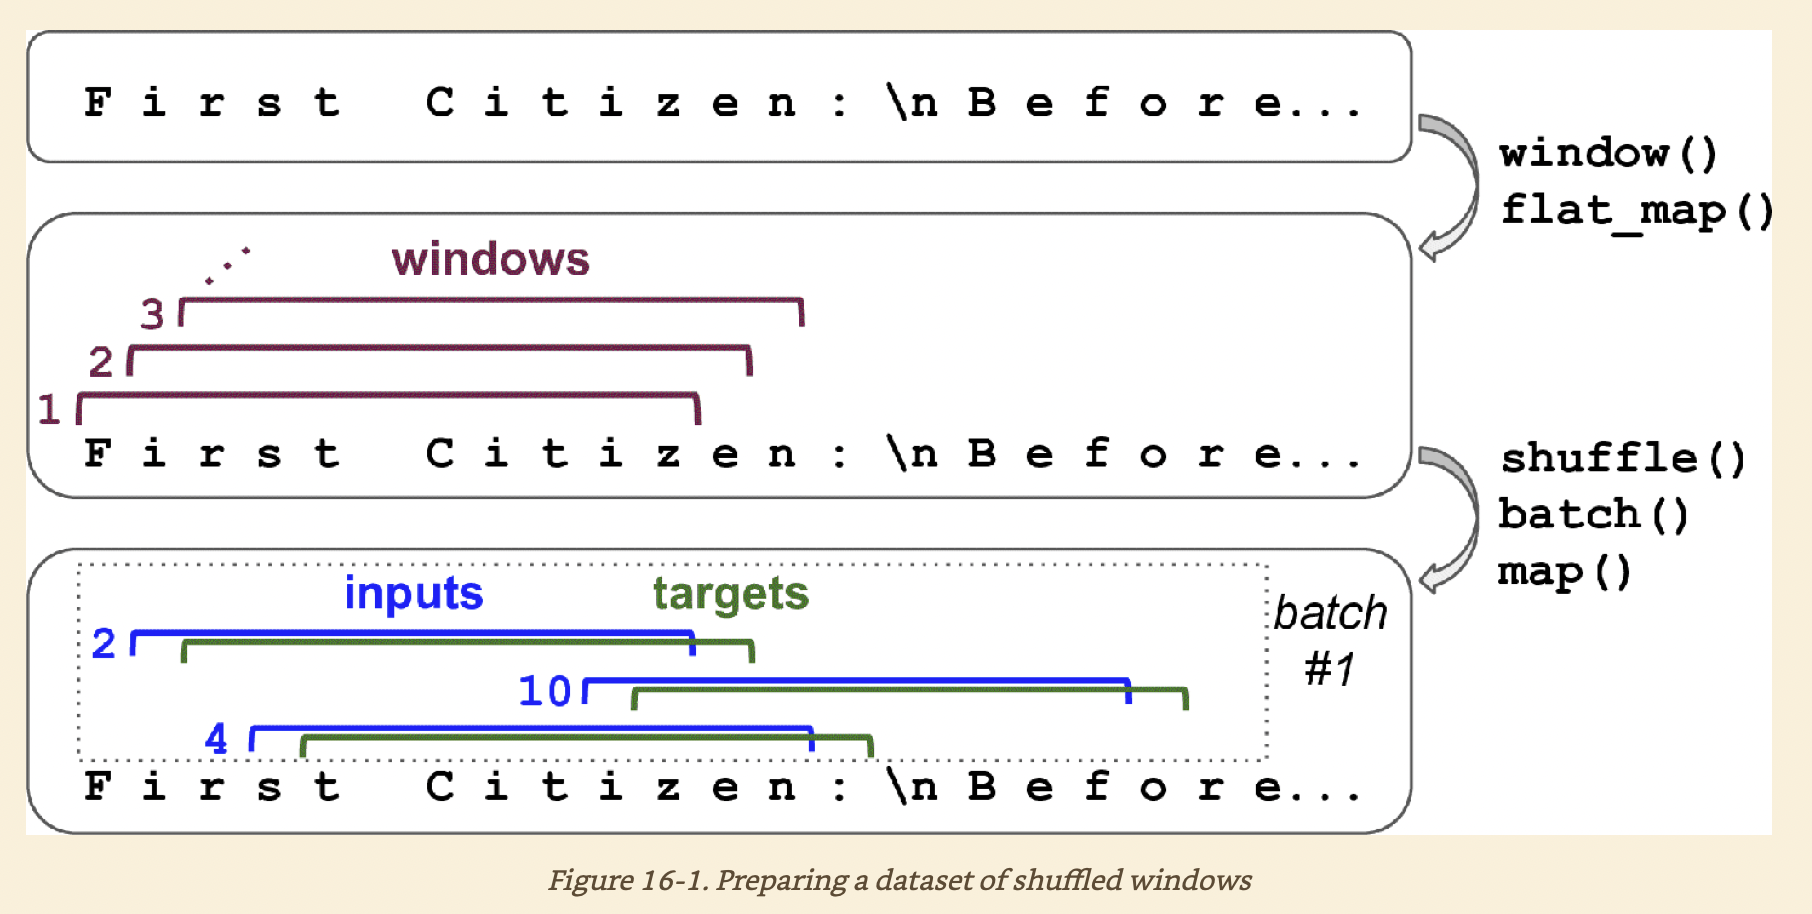

* **Categorical input features should generally be encoded, usually as one-hot vector or as embeddings.**
* **Here, we will encode each character using a one-hot vector becausse there are fairly few distinct characters.**

In [35]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)

* **Finally, we just need to add prefetching**

In [36]:
dataset = dataset.prefetch(1)

### Building and Training the Char-RNN Model
* **To predict the next character based on the previous 100 characters, we can use an RNN with 2 GRU layers of 128 units each and 20% dropout on both the inputs(dropout) and the hidden states(recurrent\_dropout).**
* **The output layer is a time-distributed Dense layer. This time this layer must have 39 units(max\_id) because there are 39 distinct characters in the text, and we want to output a probability for each possible character(at each time step).**
* **The output probabilities should sum up to 1 at each time step, so we apply the softmax activations function to the Dense layer.**
* **We can compile this model, using the "sparse\_categorical\_crossentropy" loss and an Adam optimizer**
* **Finally, we are ready to train the model for several epochs(this may take many hours, depending on the network).**

In [20]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
model = keras.models.Sequential([
                                 keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                                                  dropout=0.2, recurrent_dropout=0.2),
                                 keras.layers.GRU(128, return_sequences=True, 
                                                  dropout=0.2, recurrent_dropout=0.2),
                                 keras.layers.TimeDistributed(keras.layers.Dense(max_id, 
                                                                                 activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, epochs=20)

Epoch 1/20
31368/31368 [==============================] - 7989s 255ms/step - loss: 1.5865
Epoch 2/20
31368/31368 [==============================] - 8073s 257ms/step - loss: 1.3655
Epoch 3/20
12343/31368 [==========>...................] - ETA: 1:21:43 - loss: 1.3501

### Using the Char-RNN Model
* **Now that we have a model that can predict the next character in text written by Shakespeare. To feed it some text, we first need to preprocess it like we did earlier, so let's create a function for this:**

In [ ]:
def preprocess(texts):
    X = np.array(tokenizer.texts_to_sequences(texts)) - 1
    return tf.one_hot(X, max_id)

**Let's use the model to predict the next letter in some text**

In [ ]:
X_new = preprocess(["How are you"])
Y_pred = model.predict(X_new)
tokenizer.sequences_to_texts(Y_pred + 1)[0][-1]

### Generating Fakse Shakespearean Text
* **To generate new text using the Char-RNN model, we could feed it some text, make the model predict the most likely next letter, add it at the end of the text, then give the extended text to the model to guess the next leeter, and so on.**
* **In practice, this often leads to the same wors being repeated over and over again. Instead, we can pick the next character randomly, with a probability equal to the estimated probability, using TensorFlow's** tf.random.categorical( ) **function. This will generate more diverse and interesting text.**
* **The** categorical() **function samples random calss indices, given the class log probabilites(logits). To have more control over the diversity of the generated text, we can divide the logits by a number called the *temperature*, which we can tweak as we wish: a temperature close to 0 will favor the high-probability characters, while a very high temperature will give all characters an equal probability**

* **The following** next\_char( ) **funciton uses this appraoch to pick the next character to add to the input text:**

In [ ]:
def next_char(text, temperature=1):
    X_new = preprocess([text])
    y_proba = model.predict(X_new[0, -1:, :])
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

* **Next, we can write a small function that will repeatedly call** next\_char( ) **to get the next character and append it to the given text**

In [ ]:
def complete_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

* **We are now ready to generate some text. Let's try with some different temperatures**

In [ ]:
print(complete_text("t", temperature=0.2)

In [ ]:
print(complete_text("w", temperature=1))

In [ ]:
print(complete_text("w", temperature=2))

* **To generate more convinving text, you could try using more** GRU **layers and more neurons per layer, train for longer, and add some regularization.**
* **Moreover, the model is currently incapable of learning patterns longer than** n\_steps, **which is just 100 characters.**
* **You could try making this window larger, but it will also make training harder, and even LSTM and GRU cells cannot handle very long sequences.**
* **Alternatively, you could use a stateful RNN**

### Stateful RNN
* **Until now, we have used only *stateless RNNs*: at each training iteration the model starts with a diffent state full of zeros, then it updates this state at each time step, and after the last time step, it throws it away, as it is not needed anymore.**
* **What if we told the RNN to preserve this final state after processing one training btcha and use it as the initial state for the next training batch? This way the model can learn long-term patterns despit only backpropagating through short sequences. This is called *stateful RNN*.**

##### How to build a Stateful RNN
* **A statful RNN only makes sense if each input sequence in a batch starts exactly where the corresponding sequence in teh previous batch left off.**
* **The first thing we need to do to build a stateful RNN is to use sequential and nonoverlapping input sequences*rather than the shuffles and overlapping sequences we used to train stateless RNNs)**
* **When creating the** Dataset,**we must therfore use** shift=n\_steps(**instead of** shift=1) **when calling the** window( ) **method.**
* **Moreover, we must obviouslu *not* call the** shuffle( ) **method. Unfortunately, batching is much harder when preparing a dataset for a stateful RNN than it is for a stateless RNN. The simplest solution is to just use "batches" containing a single window.**

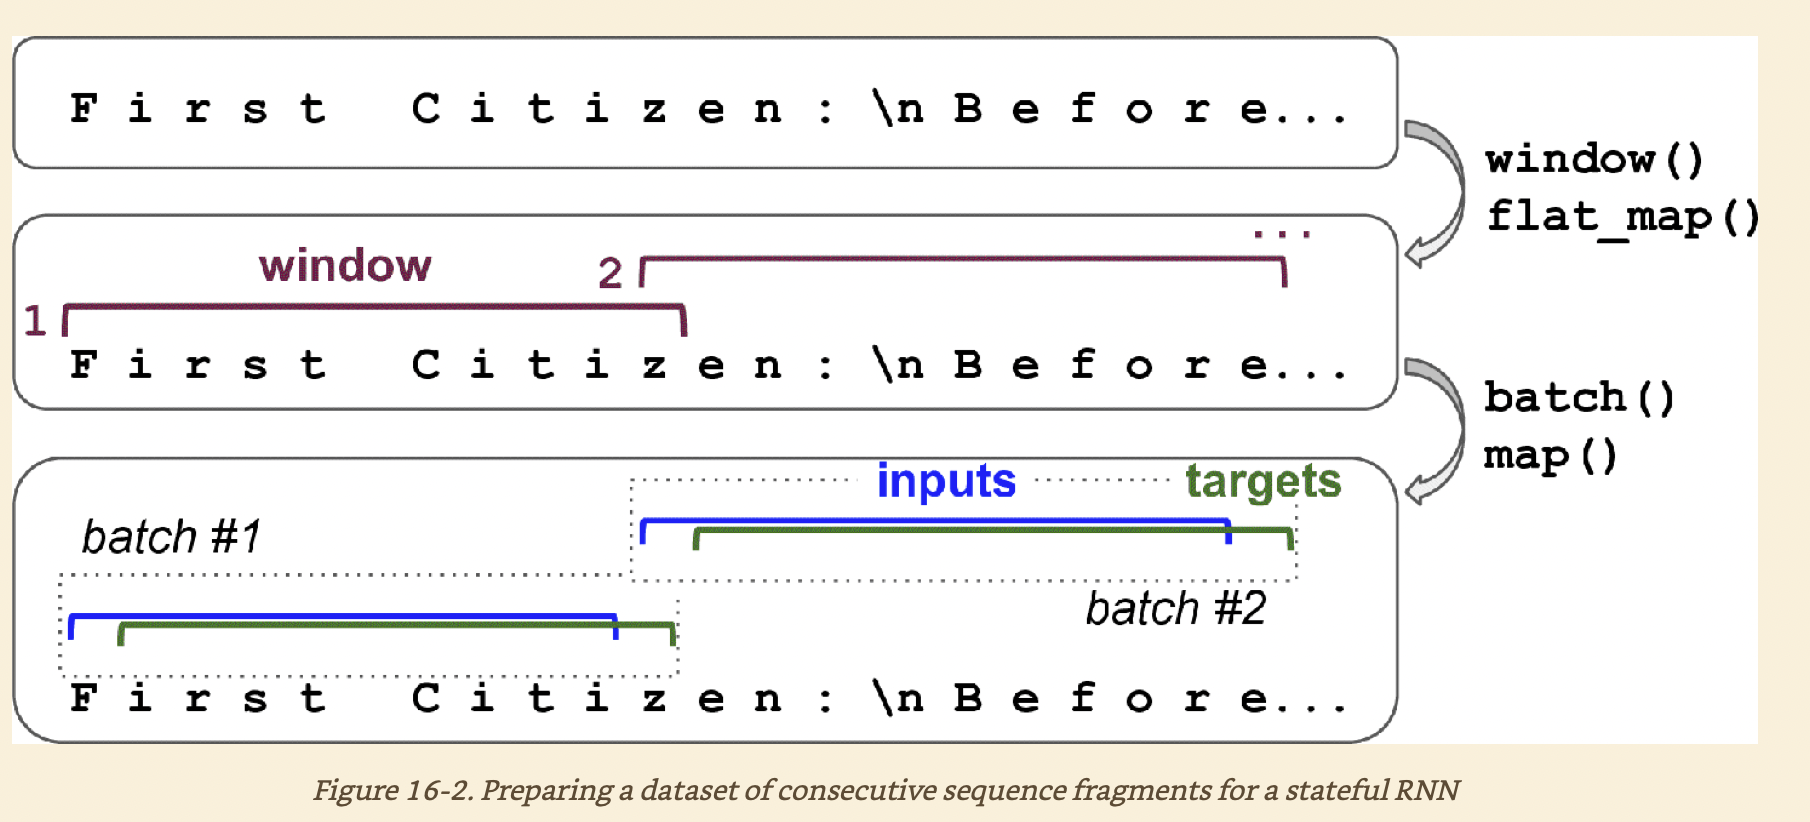

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])
dataset = dataset.window(window_length, shift=n_steps, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(window_length))
dataset = dataset.batch(1)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch)
)
dataset = dataset.prefetch(1)